# Load Data and visualization

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import h5py
import copy
import time
# print(torch.__version__)
file_name = "../data/CIFAR10.hdf5"
data = h5py.File(file_name, "r")
# get metadata for data: [n for n in data.keys()]
x_train = np.float32(data["X_train"][:]).reshape(-1, 3, 32, 32)
y_train = np.int32(np.array(data["Y_train"]))
x_test = np.float32(data["X_test"][:]).reshape(-1, 3, 32, 32)
y_test = np.int32(np.array(data["Y_test"]))
data.close()

In [2]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 3, 32, 32), (50000,), (10000, 3, 32, 32), (10000,))

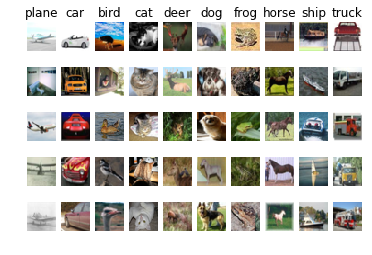

In [3]:
import matplotlib.pyplot as plt
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * len(classes) + y + 1
        plt.subplot(samples_per_class, len(classes), plt_idx)
        plt.imshow(x_train[idx].transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Data Agumentation - vertical / horizontal flip

In [4]:
def random_flip(x_train,y_train,portion=0.5, direction=2):
    """
    portion:
        portion of sample in x_train get flipped
    direction:
        2 - horizontal
        1 - vertical
    """
    all_index = x_train.shape[0]
    idx = np.random.choice(all_index, np.int(portion*all_index), replace=False)
    new = copy.deepcopy(x_train)
    new[idx,[0],:,:] = np.flip(new[idx,[0],:,:],direction)
    new[idx,[1],:,:] = np.flip(new[idx,[1],:,:],direction)
    new[idx,[2],:,:] = np.flip(new[idx,[2],:,:],direction)
    #new = torch.from_numpy(new)
    return y_train, new

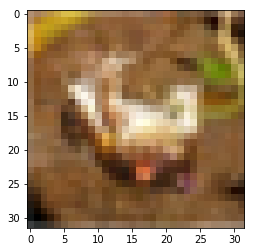

In [5]:
label, new = random_flip(x_train[[0]],y_train[0],portion=1, direction = 1)
plt.imshow(new[0].transpose(1,2,0))
plt.show()

## Model Architecture

In [6]:
class CNN_torch(nn.Module):
    def __init__(self):
        super(CNN_torch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.batch_norm1 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.batch_norm2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, bias=True)
        self.batch_norm3 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.batch_norm4 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.batch_norm5 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        #print("con0: x shape{}".format(x.shape))
        x = F.relu(self.conv1(x))
        #print("con1: x shape{}".format(x.shape))
        x = self.batch_norm1(x)
        x = F.relu(self.conv2(x))
        #print("con2: x shape{}".format(x.shape))
        x = F.dropout2d(F.max_pool2d(x, kernel_size=2, stride=2), p=0.25)
        #print("maxpool1: x shape{}".format(x.shape))
        x = F.relu(self.conv3(x))
        #print("con3: x shape{}".format(x.shape))
        x = self.batch_norm2(x)
        x = F.relu(self.conv4(x))
        #print("con4: x shape{}".format(x.shape))
        x = F.dropout2d(F.max_pool2d(x, kernel_size=2, stride=2), p=0.25)
        #print("maxpool2: x shape{}".format(x.shape))
        x = F.relu(self.conv5(x))
        #print("con5: x shape{}".format(x.shape))
        x = self.batch_norm3(x)
        x = F.relu(self.conv6(x))
        #print("con6: x shape{}".format(x.shape))
        x = F.dropout2d(x, p=0.25)
        x = F.relu(self.conv7(x))
        #print("con7: x shape{}".format(x.shape))
        x = self.batch_norm4(x)
        x = F.relu(self.conv8(x))
        #print("con8: x shape{}".format(x.shape))
        x = self.batch_norm5(x)
        x = F.dropout2d(x, p=0.25)
        #print("final: x shape{}".format(x.shape))
        x = x.view(-1, self.fc1.in_features)
        #print("flatten: x shape{}".format(x.shape))
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [15]:
model = CNN_torch()
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
batch_size = 100
num_epoch = 10
train_loss = []; train_accuracy_epcoh = []

In [16]:
# x_train = x_train[0:1000]
# y_train = y_train[0:1000]
# L_Y_train = len(y_train)
# for epoch in range(num_epoch):
#     index_permutation = np.random.permutation(L_Y_train)
#     x_train = x_train[index_permutation, :]
#     y_train = y_train[index_permutation]
#     if np.random.uniform(0,1) < 0.5:
#         y_train_aug, x_train_aug = random_flip(x_train, y_train, portion=0.6, direction=np.random.randint(1,3))
#     else:
#         y_train_aug, x_train_aug = y_train, x_train
#     x_train_aug = torch.from_numpy(x_train_aug)
#     train_accuracy = []
#     for i in range(0, L_Y_train, batch_size):
#         x_train_batch = torch.FloatTensor(x_train_aug[i:i+batch_size, :])
#         y_train_batch = torch.LongTensor(y_train_aug[i:i+batch_size])
#         data, target = Variable(x_train_batch), Variable(y_train_batch)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         if torch.__version__ == '0.4.1':
#             train_loss.append(loss.item())#loss.data[0] version conflict
#         else:
#             train_loss.append(loss.data[0])
#         # update parameters
#         optimizer.step()
#         prediction = output.data.max(1)[1]
#         accuracy = (float(prediction.eq(target.data).sum()) / float(batch_size))
#         train_accuracy.append(accuracy)
#     accuracy_epcoh = np.mean(train_accuracy)
#     print(epoch+1, accuracy_epcoh)

# # 1 0.225
# # 2 0.3
# # 3 0.377
# # 4 0.44499999999999995
# # 5 0.49000000000000005
# # 6 0.41899999999999993
# # 7 0.44000000000000006
# # 8 0.535
# # 9 0.654
# # 10 0.648

In [17]:
x_train = x_train[0:1000]
y_train = y_train[0:1000]
x_test = x_test[0:100]
y_test = y_test[0:100]
L_Y_train = len(y_train)
L_Y_test = len(y_test)
model.train()
for epoch in range(num_epoch):
    index_permutation = np.random.permutation(L_Y_train)
    x_train = x_train[index_permutation, :]
    y_train = y_train[index_permutation]
    if np.random.uniform(0,1) < 0.5:
        y_train_aug, x_train_aug = random_flip(x_train, y_train, portion=0.6, direction=np.random.randint(1,3))
    else:
        y_train_aug, x_train_aug = y_train, x_train
    x_train_aug = torch.from_numpy(x_train_aug)
    train_accuracy = []
    for i in range(0, L_Y_train, batch_size):
        x_train_batch = torch.FloatTensor(x_train_aug[i:i+batch_size, :])
        y_train_batch = torch.LongTensor(y_train_aug[i:i+batch_size])
        if use_cuda:
            data, target = Variable(x_train_batch).cuda(), Variable(y_train_batch).cuda()
        else:
            data, target = Variable(x_train_batch), Variable(y_train_batch)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if torch.__version__ == '0.4.1':
            train_loss.append(loss.item())
        else:
            train_loss.append(loss.data[0])
        # update parameters
        optimizer.step()
        prediction = output.data.max(1)[1]
        accuracy = (float(prediction.eq(target.data).sum()) / float(batch_size))
        train_accuracy.append(accuracy)
    train_accuracy_epcoh.append(np.mean(train_accuracy)) 
    print("Epoch: {} | Loss: {} | Accuracy::{}".format(epoch+1, train_loss[-1], train_accuracy_epcoh[-1]))

Epoch: 1 | Loss: 1.9041553735733032 | Accuracy::0.23600000000000004
Epoch: 2 | Loss: 1.7524278163909912 | Accuracy::0.348
Epoch: 3 | Loss: 1.71491277217865 | Accuracy::0.41500000000000004
Epoch: 4 | Loss: 1.3278553485870361 | Accuracy::0.5050000000000001
Epoch: 5 | Loss: 1.6284995079040527 | Accuracy::0.38899999999999996
Epoch: 6 | Loss: 1.4118293523788452 | Accuracy::0.42699999999999994
Epoch: 7 | Loss: 1.6123847961425781 | Accuracy::0.421
Epoch: 8 | Loss: 1.3659138679504395 | Accuracy::0.5660000000000001
Epoch: 9 | Loss: 1.0177937746047974 | Accuracy::0.6020000000000001
Epoch: 10 | Loss: 0.9154093265533447 | Accuracy::0.701


In [18]:
model.eval()
test_accuracy = []
for i in range(0, L_Y_test, batch_size):
    x_test_batch = torch.FloatTensor(x_test[i:i+batch_size, :])
    y_test_batch = torch.LongTensor(y_test[i:i+batch_size])
    if use_cuda:
        data, target = Variable(x_train_batch).cuda(), Variable(y_train_batch).cuda()
    else:
        data, target = Variable(x_train_batch), Variable(y_train_batch)
    output = model(data)
    loss = F.nll_loss(output, target)
    prediction = output.data.max(1)[1]
    accuracy = (float(prediction.eq(target.data).sum()) / float(batch_size))
    test_accuracy.append(accuracy)
accuracy_test = np.mean(test_accuracy)
print("trained on [{}] epoch, with test accuracy [{}]".format(num_epoch, accuracy_test))

trained on [10] epoch, with test accuracy [0.69]


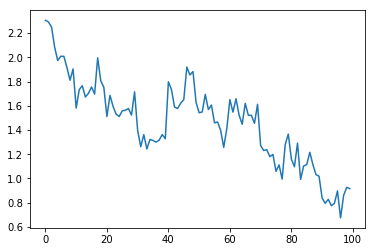

In [19]:
plt.plot(train_loss)
plt.show()

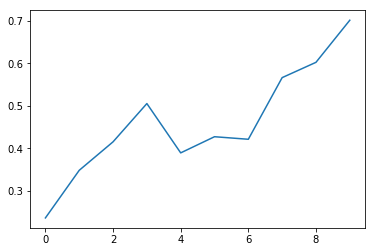

In [20]:
plt.plot(train_accuracy_epcoh)
plt.show()

In [21]:
torch.save(model.state_dict(), 'saved_model_state.pt')